# Demo for MMA Localization:

Authors: Amanda Beck, Zsuzsa Marka

## Appendix:

1. [GW170817 Binary Neutron Star Merger and Neutrino Overlap](#GW170817-Binary-Neutron-Star-Merger-and-Neutrino-Overlap:)
    1. [BNS Data](#BNS-Data:)
        1. [Isolating BNS 90% Probability Area](#Isolating-BNS-90%-Probability-Area:)
        2. [Finding Highest Probability Pixel](#Finding-Highest-Probability-Pixel:)
    3. [Fermi Sub-threshold GCN (Gamma-ray Coordinates Network) Data](#Fermi-Sub-threshold-GCN-(Gamma-ray-Coordinates-Network)-Data:)
        1. [Isolating GRB 90% Probability Area](#Isolating-GRB-90%-Probability-Area:)
2. [BBH and AllWISE Crossmatch](#BBH-and-AllWISE-AGN-Overlap:)
3. [Hopskotch Demo](#Hopskotch-GCN-Circular-Imports:)


In [1]:
# imports:
from astropy.coordinates import SkyCoord, Galactic, ICRS, FK5
from astropy.table import Column, Table, join
from ligo.skymap.postprocess import contour
from ligo.skymap.io import read_sky_map
from matplotlib import pyplot as plt
from astropy_healpix import HEALPix
import astropy.coordinates as coord
from astropy.io import fits, ascii
import astropy.units as u
import ligo.skymap.plot
import ligo.skymap.moc
import healpy as hp
import numpy as np
import scipy
import math
%matplotlib inline

## GW170817 Binary Neutron Star Merger and Neutrino Overlap:

### BNS Data:

In [2]:
# opening BNS LIGO data:
GW170817 = '../data/GW170817_skymap.fits' 
bns_data = Table.read(GW170817, 
                      format='fits')

# adding an index row to prevent pixel scrambling:
index = Column(np.arange(len(bns_data)), 
               name='INDEX')
bns_data.add_column(index, 
                    index=0)

bns_data

INDEX,PROB,DISTMU,DISTSIGMA,DISTNORM
,1 / pix,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
0,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
1,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
2,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
3,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
4,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
5,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
6,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
7,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716


In [3]:
fits.getheader('../data/GW170817_skymap.fits', 1)

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =             12582912 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'PROB    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'pix-1   '                                                            
TTYPE2  = 'DISTMU  '                                                            
TFORM2  = 'D       '        

#### Isolating BNS 90% Probability Area:

In [4]:
# isolating 90% probability area:
def isolate_90_area(data, 
                    order=None):
    ''' 
    Isolates the 90% highest probability area.

    Parameters:
    -----------
    data: Table or DataFrame
        LIGO data containing pixel probability column.
        
    Returns:
    -----------
    ninety_area: Table or DataFrame
        Isolated 90% probability area pixels of the LIGO data.  
    '''
    # ordering table by probability:
    data = np.sort(data, order=order)
    # adding from top to bottom till 90% prob area:
    data = Table(data)[::-1]
    s = 0
    for i in range(len(data['PROB'])):
        ninety_area = data[:i]
        s += data['PROB'][i]
        if (s >= 0.9):
            break
    
    return ninety_area

In [5]:
bns_ninety_area = isolate_90_area(bns_data, 
                                  order='PROB')
bns_ninety_area

INDEX,PROB,DISTMU,DISTSIGMA,DISTNORM
int64,float64,float64,float64,float64
6376622,0.00048614700519965644,35.17109105811737,7.481757282146153,0.0007734057725451106
6376620,0.00048540165639012124,35.39640936254927,7.4403039693594675,0.00076437176672537
6376965,0.0004849726578483823,35.56625470072729,7.357269518332313,0.0007580996011745014
6376623,0.0004838749862290262,35.785849123662715,7.317852152527875,0.0007495252006670972
6376964,0.00048347454237884465,34.96216240876593,7.525045955287046,0.0007818735994090918
6376611,0.00048328093520594604,35.03165136030263,7.565787498206285,0.0007785386603684383
6376617,0.0004830104634942047,34.826042919615375,7.609347112169375,0.0007869334930040232
6376967,0.00048264988532099277,35.34956614269714,7.397416748617443,0.0007666867859909103
6376614,0.00048154901649010134,35.63057255596844,7.399143308692568,0.0007551244522832314


#### Finding Highest Probability Pixel:

In [6]:
# find highest probability pixel (my own way):
bns_highest_prob = bns_ninety_area[bns_ninety_area['PROB'] == np.amax(bns_ninety_area['PROB'])]
hp.pix2ang(hp.get_nside(bns_data['PROB']), bns_highest_prob['INDEX'], nest=True, lonlat=True)

(<Column name='INDEX' dtype='float64' length=1>
 196.30371093749997, <Column name='INDEX' dtype='float64' length=1>
 -21.30184610840405)

### Fermi Sub-threshold GCN (Gamma-ray Coordinates Network) Data:

In [7]:
# opening BNS LIGO data:
F170817 = '../data/F170817_13.fits'
data = Table.read(F170817)

data

PROBABILITY [1024],SIGNIFICANCE [1024]
float32,float32
5.158274e-05 .. 8.2165316e-05,0.26613468 .. 0.42392164
5.7483585e-06 .. 3.0052884e-06,0.029657934 .. 0.015505408
0.000106213774 .. 0.00013513463,0.54799664 .. 0.69721013
8.1101374e-05 .. 2.702895e-05,0.41843238 .. 0.13945247
3.065457e-07 .. 4.7087744e-07,0.001581584 .. 0.0024294332
5.3288534e-08 .. 5.9065615e-09,0.0002749355 .. 3.0474162e-05
3.1502657e-06 .. 7.783097e-07,0.0162534 .. 0.004015591
4.5463025e-07 .. 5.251986e-09,0.0023456078 .. 2.7096963e-05
8.548238e-05 .. 0.000115458446,0.4410356 .. 0.59569335


In [8]:
fits.getheader('../data/F170817_13.fits', 1)

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 8192 / length of dimension 1                          
NAXIS2  =                  192 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'PROBABILITY'        / Differential probability per pixel             
TFORM1  = '1024E   '                                                            
TTYPE2  = 'SIGNIFICANCE'       / Integrated probability                         
TFORM2  = '1024E   '                                                            
PIXTYPE = 'HEALPIX '        

In [9]:
data['PROBABILITY'].shape

(192, 1024)

In [10]:
# concatenating pixel arrays to get full map:
gbm_prob = np.concatenate((data['PROBABILITY']))
gbm_prob

array([5.1582741e-05, 4.9343795e-05, 5.6032834e-05, ..., 3.5819894e-09,
       3.1977319e-09, 3.5312013e-09], dtype=float32)

In [11]:
# creating table with full map and index:
gbm_data = Table()
gbm_data['PROB'] = gbm_prob
gbm_data['INDEX'] = np.arange(len(gbm_prob))

In [12]:
gbm_data

PROB,INDEX
float32,int64
5.158274e-05,0
4.9343795e-05,1
5.6032834e-05,2
5.3568343e-05,3
4.7041394e-05,4
4.4675562e-05,5
5.126602e-05,6
4.958198e-05,7
6.0772105e-05,8


#### Isolating GRB 90% Probability Area:

In [13]:
gbm_ninety_area = isolate_90_area(gbm_data, order='PROB')

In [14]:
gbm_ninety_area

PROB,INDEX
float32,int64
0.00019308114,8860
0.00019302715,8857
0.00019271714,8862
0.0001926637,8859
0.00019265607,8863
0.00019263176,8854
0.00019255606,8861
0.00019255471,8905
0.00019249636,8858


### IceCube Neutrino Data:

In [15]:
IceCube = '../data/icecube_10year_ps/events/IC86_VI_exp.csv'
n_data = ascii.read(IceCube, data_start=1, delimiter=' ', format='csv')

n_data

MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
float64,float64,float64,float64,float64,float64,float64
57528.87234241,2.93,0.62,296.414,39.089,346.423,129.134
57528.87408644,3.68,0.72,352.429,-3.112,290.977,86.981
57528.87733405,2.97,1.59,262.432,17.035,22.168,107.028
57528.87801159,2.98,0.23,51.371,22.266,233.424,112.318
57528.87907391,3.05,0.9,255.736,59.652,29.617,149.633
57528.87960696,3.02,0.29,244.072,-1.872,41.317,88.091
57528.88107602,3.02,2.78,85.551,21.63,200.344,111.631
57528.88298032,2.86,0.3,275.852,43.615,10.846,133.629
57528.8869736,4.61,0.55,142.68,-79.481,145.664,10.434


In [16]:
n_data[86958] # neutrino closest in timing to GW170817
# convert from MJD to UTC time
# write to print all which is within +- 500 secs (~3-5)

MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
float64,float64,float64,float64,float64,float64,float64
57782.34200181,2.92,0.72,311.788,3.686,29.897,93.752


### Plotting:

In [17]:
DPI = 200
WIDTH = 6  # [inches]
HEIGHT = 4  # [inches]
LEFT_SHIFT_COEFF = 1/20.  # quadratic curve dec labels away from meridian
LEFT_SHIFT_BASE = -20  # baseline shift from leftmost meridian [deg]
XMARGIN = 0.4  # additional margin in x (make sure text fits) [inches]
TOPMARGIN = -0.0  # additional margin at top [inches]
BOTTOMMARGIN = -0.0  # additional margin at bottom [inches]
DEC_X_OFFSET = -0.37  # [inches]
DEC_Y_OFFSET = -0.02  # [inches]
RA_X_OFFSET = 0  # [inches]
RA_Y_OFFSET = 0.06  # [inches]
N_X_OFFSET = 0.08  # [inches]
N_Y_OFFSET = 0.08  # [inches]
CENTRAL_LON = 180  # longitude to place at center of skymap [deg]
CENTRAL_LAT = 0  # latitude to place at center of skymap [deg]
BNS_RA = 196.4500
BNS_DEC = -21.3814
PSI = 0  # additional rotation of skymap about center
DELTA_PARALLEL = 15  # space between parallels in the graticule [deg]
DELTA_MERIDIAN = 30  # space between meridians in the graticule [deg]
GRATICULE_COLOR = "#B0B0B0"
GRATICULE_LABEL_COLOR = (0.2, 0.2, 0.2)
MERIDIAN_FONT_SIZE = 11
FONT_SIZE = 14  # matplotlib font size
UNCERTAINTY_ALPHA = 0.4  # opacity in [0,1] for scatterplot uncertainty discs
DEFAULT_PLOT_EXTENSION = 'pdf'  # file type to save plots as

def plot_mollview(skymap,
                  nest,
                  title=None,
                  unit="Prob. Density",
                  central_longitude=CENTRAL_LON,
                  central_latitude=CENTRAL_LAT,
                  rotation_about_center=PSI,
                  dpi=DPI,
                  graticule=15,
                  cbar=None,
                  cmap=None,
                  **kwargs):
    ''' 
    Function to plot with the RA and DEC in Mollweid view.

    Parameters:
    -----------
    skymap: NdArray or Column
        Column containing pixel data.
    nest: Boolean
        True if data is nested. 
        Default: False (ring ordering)
    title: Str
        Title of the plot. 
        Default: None
    unit: Str
        Unit to be written on colorbar (if True). 
        Default: 'Prob. Density'
    central_longitude: Float [deg]
        Longitude desired for center of skymap.
        Default: 180 [deg]
    central_latitude: Float [deg]
        Latitude desired for center of skymap.
        Default: 0 [deg]
    rotation_about_center: Float [deg]
        Additional rotation of skymap about the center.
        Default: 0 [deg]
    dpi: Float
        Default: 200
    graticule: Int
        Spacing between graticule lines.
        Default: 15
    cbar: Boolean
        If True, show color bar.
    cmap: Str
        Color map. From Matplotlib cmap.
        Default: None
        
    Returns:
    -----------
    fig: Figure
        Final skymap.
    '''
    
    from matplotlib.transforms import ScaledTranslation
    kwargs['rot'] = kwargs.get('rot', (180, 0, 0))
    
    
    hp.mollview(skymap, 
                nest=nest, 
                cmap=cmap,  
                unit=unit, 
                rot=(central_longitude, central_latitude, rotation_about_center),
                cbar=cbar)
    hp.graticule(graticule)
    
    # size the figure
    fig = plt.gcf() # gcf = get current figure
    fig.set_size_inches(WIDTH, HEIGHT)
    fig.set_dpi(dpi)
    if title is not None:
        plt.title(title)
        
    # add extra margin so that the declination labels fit
    x_1, x_2, y_1, y_2 = plt.axis()
    plt.axis((x_1-XMARGIN, x_2+XMARGIN, y_1-TOPMARGIN, y_2+BOTTOMMARGIN))
    
    # Make a matplotlib translation to offset text labels by a bit so that
    # they don't cover up the scatter plot markers they are labeling. See:
    # https://matplotlib.org/users/transforms_tutorial.html
    transdata = plt.gca().transData # gca = get current axis
    dectrans = transdata + ScaledTranslation(DEC_X_OFFSET, DEC_Y_OFFSET, fig.dpi_scale_trans)
    ratrans = transdata + ScaledTranslation(RA_X_OFFSET, RA_Y_OFFSET, fig.dpi_scale_trans)
    
    # add a graticule
    hp.graticule(DELTA_PARALLEL,
                 DELTA_MERIDIAN,
                 color=GRATICULE_COLOR,)
    
    # label declinations
    for dec in np.arange(DELTA_PARALLEL-90, 90, DELTA_PARALLEL):
        hp.projtext(# curve dec labels away from leftmost meridian
                    LEFT_SHIFT_BASE+abs(dec*LEFT_SHIFT_COEFF)**2,
                    dec,
                    # label dec, right-pad to avoid hitting plot
                    str(dec) + '$\\degree$',
                    lonlat=True,
                    color=GRATICULE_LABEL_COLOR,
                    transform=dectrans,
                    horizontalalignment='right',
                    verticalalignment='center')
    # label right ascensions
    for right_ascension in np.arange(DELTA_MERIDIAN, 
                                     360, 
                                     DELTA_MERIDIAN):
        hp.projtext(right_ascension,
                    0,
                    str(right_ascension) + '$\\degree$',
                    lonlat=True,
                    color=GRATICULE_LABEL_COLOR,
                    transform=ratrans,
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    fontsize=MERIDIAN_FONT_SIZE)
    return fig

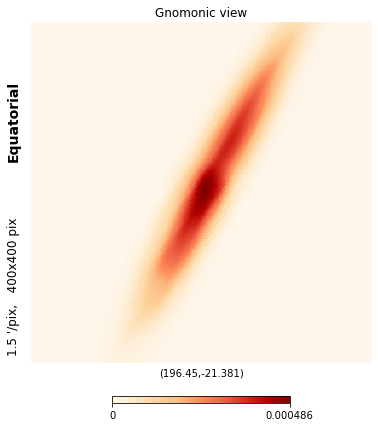

In [18]:
hp.gnomview(bns_data['PROB'], 
            nest=True, 
            cmap='OrRd',
            rot=(BNS_RA, BNS_DEC, PSI),
            coord='C',
            xsize=400)

0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


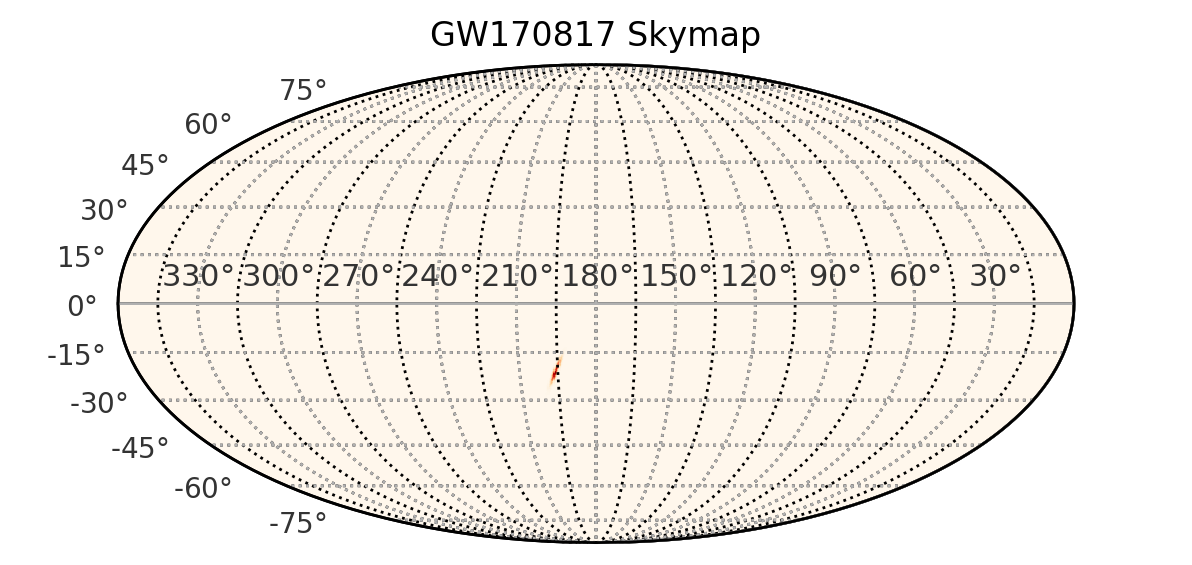

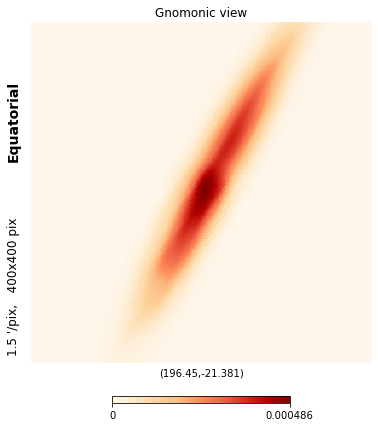

In [19]:
plot_mollview(bns_data['PROB'], 
              nest=True, 
              cmap='OrRd', 
              title='GW170817 Skymap')
plt.savefig('../plots/BNS_Skymap.pdf', 
            overwrite=True)

hp.gnomview(bns_data['PROB'], 
            nest=True, 
            cmap='OrRd',
            rot=(BNS_RA, BNS_DEC, PSI),
            coord='C',
            xsize=400)

0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


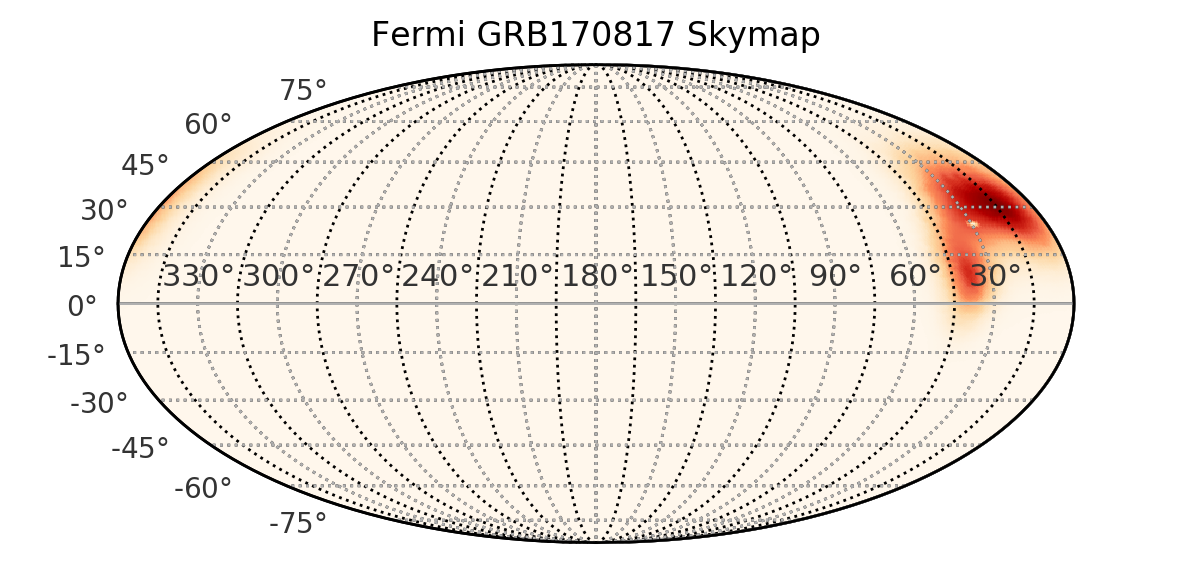

In [20]:
# plots correctly!
plot_mollview(gbm_data['PROB'], 
              nest=True, 
              cmap='OrRd', 
              title='Fermi GRB170817 Skymap')
plt.savefig('../plots/gbm_Skymap.pdf', 
            overwrite=True)

In [21]:
# getting contours for gbm:
gbm_contour = contour(gbm_data['PROB'], 
                      levels=[50, 90], 
                      nest=True, 
                      simplify=False)

In [22]:
gbm_contour

[[], []]

0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


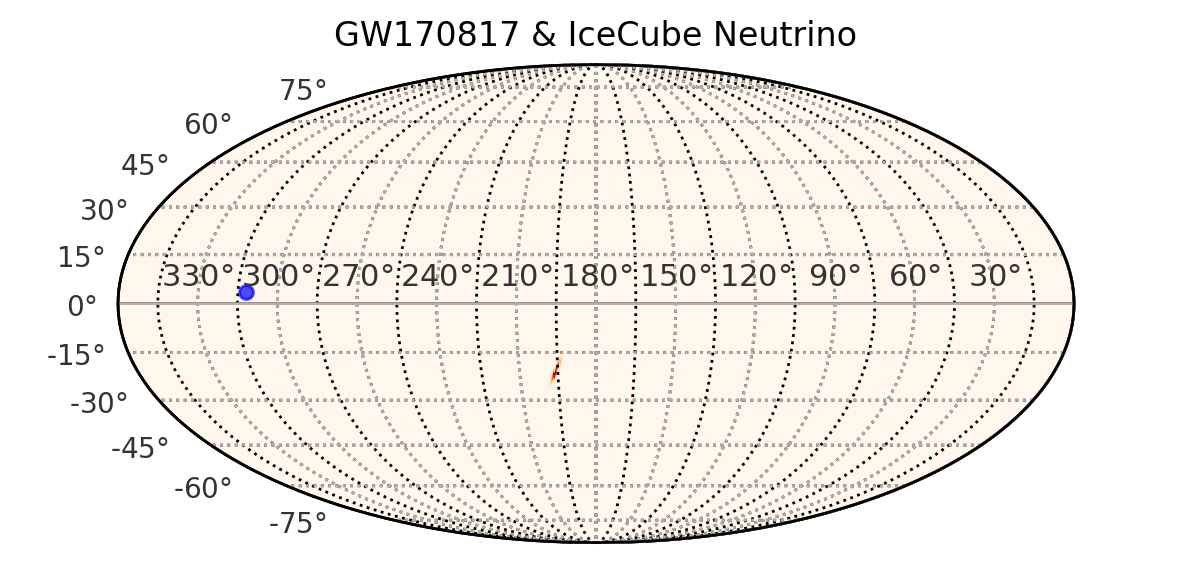

In [23]:
plot_mollview(bns_data['PROB'], 
              nest=True, 
              cmap='OrRd', 
              title='GW170817 & IceCube Neutrino')
hp.projscatter(n_data[86958]['RA[deg]'], 
               n_data[86958]['Dec[deg]'], 
               marker='.', 
               s=100, 
               c='b', 
               lonlat=True, 
               alpha=0.7)
plt.savefig('../plots/gbm_neutrino_Skymap.pdf', overwrite=True)

## BBH and AllWISE AGN Overlap:

### BBH Data:

In [24]:
# opening BBH LIGO data:
S190521g = '../data/S190521g/bayestar2.fits' 
bbh_data = Table.read(S190521g)

bbh_data
# multiorder maps: LIGO DCC gwtc2

PROB,DISTMU,DISTSIGMA,DISTNORM
1 / pix,Mpc,Mpc,1 / Mpc2
float64,float64,float64,float64
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05


In [25]:
# adding an index row to prevent pixel scrambling:
index = Column(np.arange(len(bbh_data)), name='INDEX')
bbh_data.add_column(index, index=0)

bbh_data

INDEX,PROB,DISTMU,DISTSIGMA,DISTNORM
,1 / pix,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
0,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
1,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
2,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
4,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
5,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
6,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
7,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05


In [26]:
# getting nside value:
nside = int((len(bbh_data))/12)**(1/2)

In [27]:
bbh_ninety_area = isolate_90_area(bbh_data, order='PROB')
bbh_ninety_area

INDEX,PROB,DISTMU,DISTSIGMA,DISTNORM
int64,float64,float64,float64,float64
2140788,7.300594766653513e-05,578.6989651459575,134.65056071447785,2.8326746010215228e-06
2140790,7.299722728689103e-05,578.9672656632431,134.81122399518873,2.829837776746133e-06
2140789,7.29389530802557e-05,579.0822411319475,134.74802297664758,2.8289082668104363e-06
2140767,7.293684502413901e-05,578.8067055490524,134.5902546341876,2.831804472408014e-06
2140766,7.292514235949446e-05,578.4119804743116,134.50183436497926,2.8356635224898187e-06
2140787,7.292154195353686e-05,578.5848541112995,134.71609372018705,2.83359290283521e-06
2140793,7.290355613934275e-05,578.8463755128832,134.87939175200307,2.830811756595052e-06
2140796,7.28998063988666e-05,579.216459557833,134.98399802689323,2.827155840113906e-06
2140791,7.285160752936588e-05,579.3386406316629,134.91793374827972,2.826167292646987e-06


### AllWISE Data:

In [28]:
# opening BBH LIGO data:
cat = '../data/allwise.fits' 
allwise = Table.read(cat, format='fits')

allwise

NAME,RA,DEC,LII,BII,W1W2_COLOR,W2W3_COLOR,W1_MAG,GMAG,REDSHIFT,REDSHIFT_FLAG,LQAC2_NAME,DR12Q_NAME,MILLIQUAS_NAME
,DEGREE,DEGREE,DEGREE,DEGREE,MAG,MAG,MAG,MAG,,,,,
bytes25,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,bytes17,bytes24,bytes26
WISEA J184245.06-894911.0,280.68778,-89.81973,303.13432,-27.12127,0.95,3.48,15.15,0.00,0.00000,,,,
WISEA J043431.62-894617.9,68.63175,-89.77165,302.71954,-27.25653,1.32,3.07,15.12,0.00,0.00000,,,,
WISEA J220915.15-894514.2,332.31317,-89.75395,303.11194,-27.31510,0.95,3.57,16.08,0.00,0.00000,,,,
WISEA J094017.96-894442.8,145.07485,-89.74523,302.72023,-26.95691,0.96,3.16,14.27,0.00,0.00000,,,,
WISEA J233728.16-894436.2,354.36737,-89.74341,303.02356,-27.37156,1.04,3.00,15.21,0.00,0.00000,,,,
WISEA J024222.81-894245.1,40.59507,-89.71254,302.78126,-27.38260,1.19,3.13,15.69,0.00,0.00000,,,,
WISEA J004712.26-894157.4,11.80109,-89.69929,302.93818,-27.42891,1.24,3.19,13.66,0.00,0.00000,,,,
WISEA J051926.00-894114.2,79.85834,-89.68730,302.60814,-27.25007,1.56,3.09,15.09,0.00,0.00000,,,,


In [29]:
allwise['RA'].name = 'RAJ2000'
allwise['DEC'].name = 'DEJ2000'
allwise

NAME,RAJ2000,DEJ2000,LII,BII,W1W2_COLOR,W2W3_COLOR,W1_MAG,GMAG,REDSHIFT,REDSHIFT_FLAG,LQAC2_NAME,DR12Q_NAME,MILLIQUAS_NAME
,DEGREE,DEGREE,DEGREE,DEGREE,MAG,MAG,MAG,MAG,,,,,
bytes25,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,bytes17,bytes24,bytes26
WISEA J184245.06-894911.0,280.68778,-89.81973,303.13432,-27.12127,0.95,3.48,15.15,0.00,0.00000,,,,
WISEA J043431.62-894617.9,68.63175,-89.77165,302.71954,-27.25653,1.32,3.07,15.12,0.00,0.00000,,,,
WISEA J220915.15-894514.2,332.31317,-89.75395,303.11194,-27.31510,0.95,3.57,16.08,0.00,0.00000,,,,
WISEA J094017.96-894442.8,145.07485,-89.74523,302.72023,-26.95691,0.96,3.16,14.27,0.00,0.00000,,,,
WISEA J233728.16-894436.2,354.36737,-89.74341,303.02356,-27.37156,1.04,3.00,15.21,0.00,0.00000,,,,
WISEA J024222.81-894245.1,40.59507,-89.71254,302.78126,-27.38260,1.19,3.13,15.69,0.00,0.00000,,,,
WISEA J004712.26-894157.4,11.80109,-89.69929,302.93818,-27.42891,1.24,3.19,13.66,0.00,0.00000,,,,
WISEA J051926.00-894114.2,79.85834,-89.68730,302.60814,-27.25007,1.56,3.09,15.09,0.00,0.00000,,,,


In [30]:
def convert_RaDec_Index_manual(data, n_side):
    ''' 
    Manually converting RA and DEC to healpix nested pixel index (marginally faster than using astropy's methods).
    Adds pixel index, theta, and phi columns to data set.

    Parameters:
    -----------
    data: Table or DataFrame
        Must have Ra and Dec columns named as RAJ2000 and DEJ2000.
    n_side: float or int
        nside value corresponding to LIGO skymap to be crossmatched with the AGN data.
    '''
    n_side_array = np.full(len(data['RAJ2000']), int(n_side))
    theta = 0.5 * np.pi - np.deg2rad(data['DEJ2000'])
    phi = np.deg2rad(data['RAJ2000'])
    ipix = hp.ang2pix(n_side_array, theta, phi, nest=True)
    data.add_columns([np.array(ipix), theta, phi],
                     names=['INDEX', 'THETA', 'PHI'])

In [31]:
convert_RaDec_Index_manual(allwise, nside)
allwise

NAME,RAJ2000,DEJ2000,LII,BII,W1W2_COLOR,W2W3_COLOR,W1_MAG,GMAG,REDSHIFT,REDSHIFT_FLAG,LQAC2_NAME,DR12Q_NAME,MILLIQUAS_NAME,INDEX,THETA,PHI
,DEGREE,DEGREE,DEGREE,DEGREE,MAG,MAG,MAG,MAG,,,,,,,DEGREE,DEGREE
bytes25,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,bytes17,bytes24,bytes26,int64,float64,float64
WISEA J184245.06-894911.0,280.68778,-89.81973,303.13432,-27.12127,0.95,3.48,15.15,0.00,0.00000,,,,,2883586,3.13845,4.89893
WISEA J043431.62-894617.9,68.63175,-89.77165,302.71954,-27.25653,1.32,3.07,15.12,0.00,0.00000,,,,,2097153,3.13761,1.19785
WISEA J220915.15-894514.2,332.31317,-89.75395,303.11194,-27.31510,0.95,3.57,16.08,0.00,0.00000,,,,,2883585,3.13730,5.79996
WISEA J094017.96-894442.8,145.07485,-89.74523,302.72023,-26.95691,0.96,3.16,14.27,0.00,0.00000,,,,,2359299,3.13715,2.53203
WISEA J233728.16-894436.2,354.36737,-89.74341,303.02356,-27.37156,1.04,3.00,15.21,0.00,0.00000,,,,,2883588,3.13711,6.18488
WISEA J024222.81-894245.1,40.59507,-89.71254,302.78126,-27.38260,1.19,3.13,15.69,0.00,0.00000,,,,,2097155,3.13658,0.70852
WISEA J004712.26-894157.4,11.80109,-89.69929,302.93818,-27.42891,1.24,3.19,13.66,0.00,0.00000,,,,,2097160,3.13634,0.20597
WISEA J051926.00-894114.2,79.85834,-89.68730,302.60814,-27.25007,1.56,3.09,15.09,0.00,0.00000,,,,,2097157,3.13614,1.39379


In [32]:
def agn_counts_per_pixel(agn_index, bbh_index):
    ''' 
    Using the AGN pixel indexes, identifies how many AGN per pixel in a skymap.

    Parameters:
    -----------
    agn_indes: NdArray or Column
        AGN pixel indexes in nested ordering.
    bbh_index: NdArray or Column
        Pixel indexes in nested ordering of the current skymap. In this case, this is the INDEX column of the LIGO data.
        
    Returns:
    -----------
    agn_counts: Table or DataFrame
        AGN counts per pixel.
    hpx_map: NdArray
        AGN Healpix skymap.
    '''
    idx, counts = np.unique(agn_index, return_counts=True)
    hpx_map = np.zeros(len(bbh_index), dtype=int)
    hpx_map[idx] = counts
    agn_counts = Table([idx, counts], names=['INDEX', 'AGN COUNT'])
    
    return agn_counts, hpx_map

In [33]:
allwise_counts, allwise_hpx_map = agn_counts_per_pixel(allwise['INDEX'], bbh_data['INDEX'])
allwise_counts

INDEX,AGN COUNT
int64,int64
2,1
4,2
7,1
12,3
13,2
14,1
15,1
18,1
21,1


### Crossmatching:

In [34]:
area_matches = join(allwise, bbh_ninety_area, keys='INDEX', table_names=['AllWISE', 'LIGO'])

In [35]:
area_matches

NAME,RAJ2000,DEJ2000,LII,BII,W1W2_COLOR,W2W3_COLOR,W1_MAG,GMAG,REDSHIFT,REDSHIFT_FLAG,LQAC2_NAME,DR12Q_NAME,MILLIQUAS_NAME,INDEX,THETA,PHI,PROB,DISTMU,DISTSIGMA,DISTNORM
,DEGREE,DEGREE,DEGREE,DEGREE,MAG,MAG,MAG,MAG,,,,,,,DEGREE,DEGREE,,,,
bytes25,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,bytes17,bytes24,bytes26,int64,float64,float64,float64,float64,float64,float64
WISEA J163758.06+380842.8,249.49195,38.14524,61.15174,41.80579,1.19,3.13,14.81,0.00,0.00000,,,,,605506,0.90504,4.35446,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163827.50+380958.2,249.61459,38.16617,61.18953,41.71122,1.55,3.98,17.20,0.00,0.00000,,,,,605507,0.90467,4.35660,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163901.99+382736.6,249.75831,38.46017,61.59328,41.62076,0.76,3.08,14.75,0.00,0.00000,,,,,605511,0.89954,4.35910,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163811.46+381517.4,249.54779,38.25483,61.30272,41.77024,1.49,2.99,15.51,0.00,0.00000,,,,,605513,0.90312,4.35543,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163751.93+382630.6,249.46641,38.44186,61.54676,41.84745,1.17,3.49,15.07,0.00,0.00000,,,,,605515,0.89986,4.35401,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163817.48+382249.9,249.57285,38.38054,61.47273,41.75987,1.12,2.91,12.74,17.15,0.36100,S,LQAC2 249+038_008,,KUV 16366+3829,605516,0.90093,4.35587,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163817.16+382229.6,249.57151,38.37491,61.46511,41.76051,1.31,3.69,16.71,0.00,0.00000,,,,,605516,0.90103,4.35584,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163844.31+382725.7,249.68464,38.45716,61.58363,41.67807,1.27,2.81,15.31,19.47,1.04500,S,LQAC2 249+038_010,,SDSS J163844.30+382725.6,605517,0.89959,4.35782,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06


### Plotting:

0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.


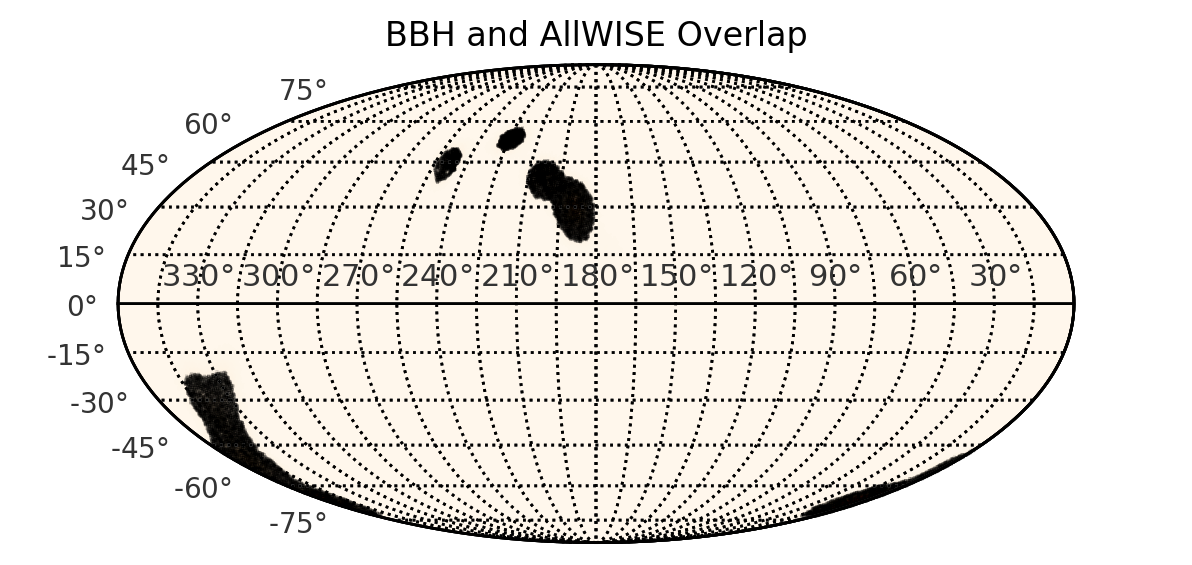

In [36]:
plot_mollview(bbh_data['PROB'], nest=True, cmap='OrRd', title='BBH and AllWISE Overlap', unit='Prob. Density')
hp.projscatter(area_matches['RAJ2000'], area_matches['DEJ2000'], marker='.', s=0.01, c='k', lonlat=True, alpha=0.5)
hp.graticule(15)
plt.savefig('../plots/bbh_agn_overlap.pdf', overwrite=True)

## Hopskotch GCN Circular Imports:

In [37]:
# hop-specific imports:
from hop import Stream
from hop import stream
from hop.io import StartPosition
from hop.subscribe import print_message

In [38]:
# testing connectivity:
with Stream(persist=True).open("kafka://kafka.scimma.org/sys.heartbeat", "r") as src:
    for i, message in zip(range(5), src):
        print(i, message)
# time in unix time.
# count since system is up that day.

0 {'timestamp': 1627574108545367, 'count': 90604, 'beat': 'listen'}
1 {'timestamp': 1627574109546687, 'count': 90605, 'beat': 'Listen'}
2 {'timestamp': 1627574110548011, 'count': 90606, 'beat': 'LISTEN'}
3 {'timestamp': 1627574111548337, 'count': 90607, 'beat': 'listen to my heart beat'}
4 {'timestamp': 1627574112549632, 'count': 90608, 'beat': 'listen'}


In [39]:
# making a Stream object:
stream = Stream(start_at=StartPosition.EARLIEST) # specifying where to start (EARLIEST gets all of the available)

# creating a message list:
messages = []

# printing messeges for GCN circulars:
with stream.open("kafka://kafka.scimma.org/gcn.circular", "r") as s:
    for message in s:
        messages.append(message)
        print(message)

TITLE:   GCN CIRCULAR
NUMBER:  30334
SUBJECT: Fermi GRB 210627B: Global MASTER-Net observations report
DATE:    21/06/27 20:45:45 GMT
FROM:    Vladimir Lipunov at Moscow State U/Krylov Obs  <lipunov@xray.sai.msu.ru>

V. Lipunov, E. Gorbovskoy, V.Kornilov, N.Tyurina, P.Balanutsa, A.Kuznetsov, F.Balakin,
V.Vladimirov, D. Vlasenko, I.Gorbunov, D.Zimnukhov, V.Senik, T.Pogrosheva,
D.Kuvshinov,  D. Cheryasov
(Lomonosov Moscow State University, SAI, Physics Department),

R. Podesta, C.Lopez, F. Podesta, C.Francile
(Observatorio Astronomico Felix Aguilar OAFA),

R. Rebolo, M. Serra
(The Instituto de Astrofisica de Canarias),

D. Buckley
(South African Astronomical Observatory),

O.A. Gres, N.M. Budnev, O.Ershova
(Irkutsk State University, API),

A. Tlatov, D. Dormidontov
(Kislovodsk Solar Station of the Pulkovo Observatory),

V. Yurkov, A. Gabovich, Yu. Sergienko
(Blagoveschensk Educational State University)




MASTER-SAAO robotic telescope  (Global MASTER-Net: http://observ.pereplet.ru, Lipu

TITLE:   GCN CIRCULAR
NUMBER:  30491
SUBJECT: Swift GRB 210723A: Global MASTER-Net observations report
DATE:    21/07/23 23:16:55 GMT
FROM:    Vladimir Lipunov at Moscow State U/Krylov Obs  <lipunov@xray.sai.msu.ru>

V. Lipunov, E. Gorbovskoy, V.Kornilov, N.Tyurina, P.Balanutsa, A.Kuznetsov, F.Balakin,
V.Vladimirov, D. Vlasenko, I.Gorbunov, D.Zimnukhov, V.Senik, T.Pogrosheva,
D.Kuvshinov,  D. Cheryasov
(Lomonosov Moscow State University, SAI, Physics Department),

R. Podesta, C.Lopez, F. Podesta, C.Francile
(Observatorio Astronomico Felix Aguilar OAFA),

R. Rebolo, M. Serra
(The Instituto de Astrofisica de Canarias),

D. Buckley
(South African Astronomical Observatory),

O.A. Gres, N.M. Budnev, O.Ershova
(Irkutsk State University, API),

A. Tlatov, D. Dormidontov
(Kislovodsk Solar Station of the Pulkovo Observatory),

V. Yurkov, A. Gabovich, Yu. Sergienko
(Blagoveschensk Educational State University)




MASTER-OAFA robotic telescope  (Global MASTER-Net: http://observ.pereplet.ru, Lipu

TITLE:   GCN CIRCULAR
NUMBER:  30493
SUBJECT: GRB 210723A: Swift-XRT refined Analysis
DATE:    21/07/24 11:06:33 GMT
FROM:    Phil Evans at U of Leicester  <pae9@leicester.ac.uk>

A.P. Beardmore (U. Leicester), P.A. Evans (U. Leicester), E. Ambrosi
(INAF-IASFPA) , M. Capalbi (INAF-IASFPA), M. Perri (SSDC & INAF-OAR),
J.A. Kennea (PSU), A. Tohuvavohu (U. Toronto), B. Sbarufatti (PSU),
J.P. Osborne (U. Leicester) and T. Sbarrato report on behalf of the
Swift-XRT team:

We have analysed 6.3 ks of XRT data for GRB 210723A (Sbarrato et al.
GCN Circ. 30485), from 79 s to 57.3 ks after the  BAT trigger. The data
comprise 267 s in Windowed Timing (WT) mode (the first 9 s were taken
while Swift was slewing) with the remainder in Photon Counting (PC)
mode. Using 3236 s of PC mode data and 6 UVOT images, we find an
enhanced XRT position (using the XRT-UVOT alignment and matching UVOT
field sources to the USNO-B1 catalogue): RA, Dec = 121.72115, -32.88570
which is equivalent to:

RA (J2000): 08h 0

In [40]:
messages[0].serialize()['content']['header']

{'title': 'GCN CIRCULAR',
 'number': '30334',
 'subject': 'Fermi GRB 210627B: Global MASTER-Net observations report',
 'date': '21/06/27 20:45:45 GMT',
 'from': 'Vladimir Lipunov at Moscow State U/Krylov Obs  <lipunov@xray.sai.msu.ru>'}

In [41]:
# creating a list of readable messages:
readable_messages = []

# serializing messages into readable dictionaries:
for m in messages:
    readable_messages.append(m.serialize())

In [42]:
readable_messages

[{'format': 'circular',
  'content': {'header': {'title': 'GCN CIRCULAR',
    'number': '30334',
    'subject': 'Fermi GRB 210627B: Global MASTER-Net observations report',
    'date': '21/06/27 20:45:45 GMT',
    'from': 'Vladimir Lipunov at Moscow State U/Krylov Obs  <lipunov@xray.sai.msu.ru>'},
   'body': 'V. Lipunov, E. Gorbovskoy, V.Kornilov, N.Tyurina, P.Balanutsa, A.Kuznetsov, F.Balakin,\nV.Vladimirov, D. Vlasenko, I.Gorbunov, D.Zimnukhov, V.Senik, T.Pogrosheva,\nD.Kuvshinov,  D. Cheryasov\n(Lomonosov Moscow State University, SAI, Physics Department),\n\nR. Podesta, C.Lopez, F. Podesta, C.Francile\n(Observatorio Astronomico Felix Aguilar OAFA),\n\nR. Rebolo, M. Serra\n(The Instituto de Astrofisica de Canarias),\n\nD. Buckley\n(South African Astronomical Observatory),\n\nO.A. Gres, N.M. Budnev, O.Ershova\n(Irkutsk State University, API),\n\nA. Tlatov, D. Dormidontov\n(Kislovodsk Solar Station of the Pulkovo Observatory),\n\nV. Yurkov, A. Gabovich, Yu. Sergienko\n(Blagoveschensk Ed

In [43]:
# make list of messages matching what we want (IceCube events):
IceCube_messages = []
other_messages = []

for i in range(len(readable_messages)):
    if ('IceCube observation of a high-energy neutrino candidate' in 
        readable_messages[i]['content']['header']['subject']):
        IceCube_messages.append(readable_messages[i])
    else:
        other_messages.append(readable_messages[i])

In [44]:
IceCube_messages

[{'format': 'circular',
  'content': {'header': {'title': 'GCN CIRCULAR',
    'number': '30468',
    'subject': 'IceCube-210717A: IceCube observation of a high-energy neutrino candidate track-like event',
    'date': '21/07/18 15:22:53 GMT',
    'from': 'Cristina Lagunas Gualda at DESY  <cristina.lagunas@desy.de>'},
   'body': 'The IceCube Collaboration (http://icecube.wisc.edu/) reports:\n\nOn 21/07/17 at 15:45:19.48 UT IceCube detected a high-energy starting event [1]. The IceCube online selection did not identify this event as a Gold or Bronze starting track. However, based on advanced reconstructions performed offline, we identify this event as a potential astrophysical neutrino of interest to the community, given its topology and light deposition. Because the event was not identified as either Gold or Bronze, we do not currently report a false alert rate or signalness. The IceCube detector was in a normal operating state at the time of detection.\n\nAdvanced reconstruction algorit

In [45]:
# creating empty skymap:
n_side_empty = 128
n_pix_empty = hp.nside2npix(n_side_empty)
hpix_empty = np.zeros(n_pix_empty)

# defining central coordinates and radius:
cent_ra = 46.49 # central RA [deg] rotated 180 for the plotting convention.
cent_dec = -1.34 # central DEC [deg]
radius = 2.7525*u.deg # averaged errors on ra and dec for simplicity of plotting a circle. [deg]

# defining offset angle array:
theta = np.linspace(0, 360, 200)*u.deg # [deg]
center = SkyCoord(cent_ra*u.deg, 
                  cent_dec*u.deg, 
                  frame='icrs')
circle = center.directional_offset_by(theta, 
                                      radius)

# defining RA and DEC of circle points:
circ_ra = circle.ra.degree
circ_dec = circle.dec.degree

In [46]:
# overlapping AllWISE with this circle:
# matches will have offset angle less than or equal to 2.7525deg
allwise_coords = SkyCoord(np.array(allwise['RAJ2000'])*u.deg, 
                          np.array(allwise['DEJ2000'])*u.deg, 
                          frame='icrs')
center_coords = SkyCoord(np.full(len(allwise_coords), cent_ra)*u.deg, 
                         np.full(len(allwise_coords), cent_dec)*u.deg, 
                         frame='icrs')

distances = center_coords.separation(allwise_coords).value
indexes_matches = np.where(distances <= 2.7525)
        
icecube_matches_ra = allwise['RAJ2000'][indexes_matches[0]]
icecube_matches_dec = allwise['DEJ2000'][indexes_matches[0]]
# this can also be done with AXS, once it is public.

len(indexes_matches[0])

849

0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


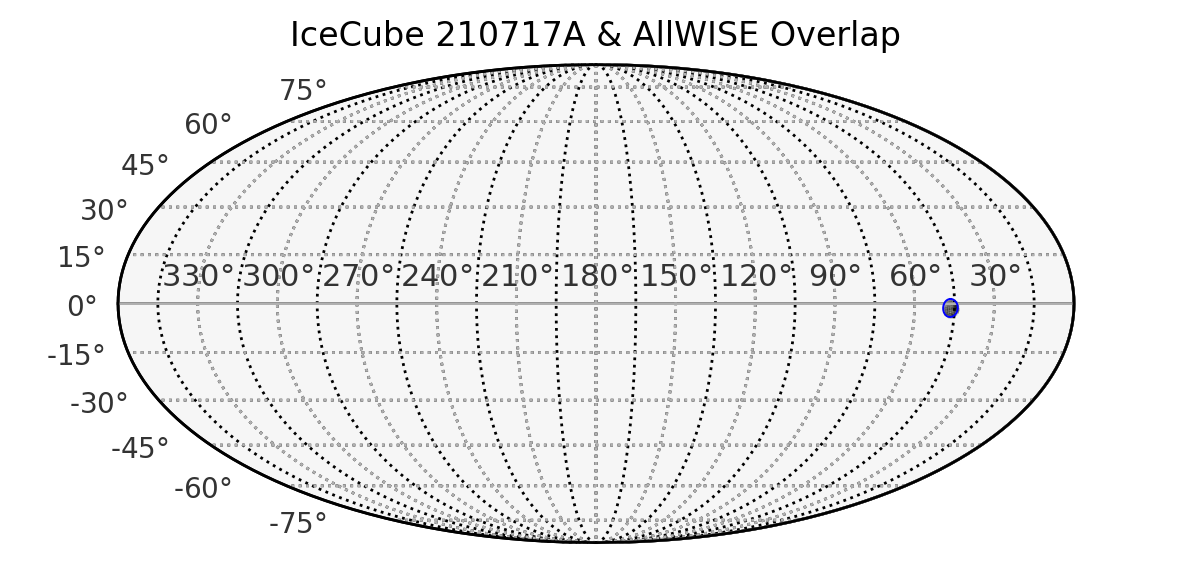

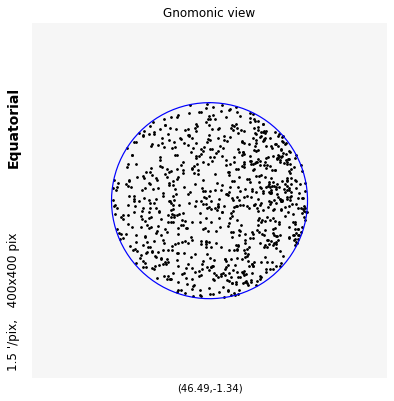

In [47]:
plot_mollview(hpix_empty, 
              nest=True, 
              cmap='PiYG', 
              title='IceCube 210717A & AllWISE Overlap', 
              cbar=False, 
              unit=None)
hp.projplot(circ_ra, 
            circ_dec, 
            lonlat=True, 
            coord='C', 
            c='b', 
            linewidth=0.7)
hp.projscatter(icecube_matches_ra, 
               icecube_matches_dec, 
               lonlat=True, 
               s=0.0001,
               c='k')

plt.savefig('../plots/IceCube_AllWISE_overlap.pdf')

hp.gnomview(hpix_empty, 
            nest=True, 
            cmap='PiYG',
            rot=(cent_ra, cent_dec, PSI),
            coord='C',
            xsize=400,
            cbar=False)
hp.projplot(circ_ra, 
            circ_dec, 
            lonlat=True, 
            coord='C', 
            c='b', 
            linewidth=1.2)
hp.projscatter(icecube_matches_ra, 
               icecube_matches_dec, 
               lonlat=True, 
               s=3, 
               c='k')

In [48]:
# opening GCN Hop data:
hop_gcn = 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2021/bn210625891/quicklook/glg_healpix_all_bn210625891.fit' 
GRB210625A = Table.read(hop_gcn, 
                        format='fits')
GRB210625A

PROBABILITY [1024],SIGNIFICANCE [1024]
float32,float32
4.0573035e-21 .. -1.0075496e-20,-9.271634e-08 .. -9.271634e-08
-4.0573035e-21 .. -6.3094777e-15,-9.271634e-08 .. -9.269906e-08
3.700701e-21 .. 1.1851671e-18,-9.271634e-08 .. -9.271634e-08
6.19607e-21 .. 3.8110736e-15,-9.271634e-08 .. -9.2703466e-08
-1.012215e-18 .. -2.0232644e-12,-9.271634e-08 .. -8.9959336e-08
-2.226298e-14 .. 8.361213e-16,-9.2666056e-08 .. -9.271361e-08
-1.0272264e-14 .. -1.4116754e-14,-9.269091e-08 .. -9.26829e-08
-1.9201572e-12 .. 3.5646856e-18,-9.009565e-08 .. -9.271634e-08
5.7937277e-22 .. 1.6259819e-16,-9.271634e-08 .. -9.271592e-08


In [49]:
# concatenating pixel arrays to get full map:
GRB210625A_prob = np.concatenate((GRB210625A['PROBABILITY']))
GRB210625A_prob

array([4.0573035e-21, 3.0764356e-21, 3.9234715e-21, ..., 1.5059754e-18,
       2.4066187e-18, 1.5061540e-18], dtype=float32)

In [50]:
# creating table with full map and index:
GRB210625A_data = Table()
GRB210625A_data['PROB'] = GRB210625A_prob
GRB210625A_data['INDEX'] = np.arange(len(GRB210625A_prob))
GRB210625A_data

PROB,INDEX
float32,int64
4.0573035e-21,0
3.0764356e-21,1
3.9234715e-21,2
7.580974e-22,3
1.2485314e-21,4
3.0764356e-21,5
2.7198333e-21,6
6.107978e-21,7
2.0955676e-21,8


0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


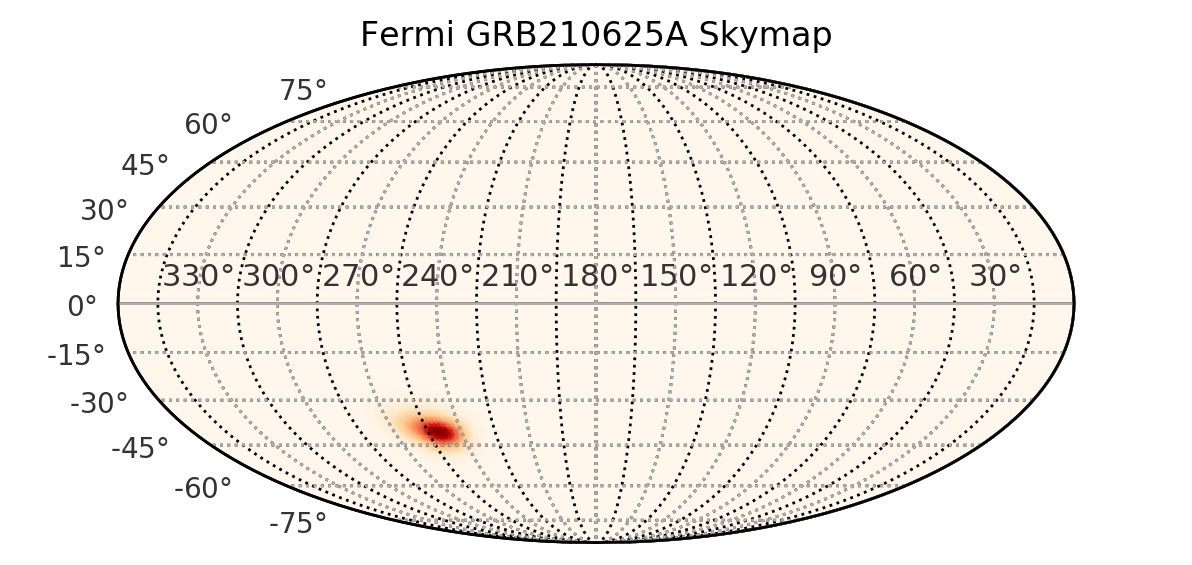

In [51]:
# plot the skymap:
plot_mollview(GRB210625A_data['PROB'], nest=True, cmap='OrRd', title='Fermi GRB210625A Skymap')
plt.savefig('../plots/gbm_hop_Skymap.pdf', overwrite=True)

## General Resources:

1. [HEALPy Documentation](https://healpy.readthedocs.io/en/latest/)
2. [GraceDB](https://gracedb.ligo.org/superevents/public/O3/)
3. [GWOSC](https://www.gw-openscience.org/about/)
4. [Fermi GCN Notices](https://gcn.gsfc.nasa.gov/fermi_gbm_subthresh_archive.html)
5. [Anaconda Documentation](https://docs.anaconda.com/anaconda/)
6. [Conda Documentation](https://docs.conda.io/projects/conda/en/latest/index.html)
7. [Conda Forge](https://conda-forge.org/docs/user/introduction.html)
8. [Finding highest prob](https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html)
9. [Install ligo-py37 Environment](https://docs.ligo.org/lscsoft/conda/environments/environment-py37.html)
10. [AllWISE AGN Catalog](https://heasarc.gsfc.nasa.gov/W3Browse/all/allwiseagn.html)
11. [GW170817 Data Release](https://dcc.ligo.org/LIGO-G1701985/public)
12. [LIGO moc Documentation](https://lscsoft.docs.ligo.org/ligo.skymap/moc/index.html)
13. [RA and DEC to Deg Converter](https://www.swift.psu.edu/secure/toop/convert.htm)
14. [Hopskotch Documentation](https://hop-client.readthedocs.io/en/latest/user/installation.html)
15. [SCiMMA Project](https://scimma.org/index.html)


### Installing LIGO conda virtual env:
```
conda activate
conda config --add channels conda-forge
wget -q https://git.ligo.org/lscsoft/conda/raw/master/environment-py37.yml
conda env create -f environment-py37.yml
```
The first line of the .yml file sets the env name to ligo-py37.
This is using python 3.7.

### Installing `hop-client`:

```
$ pip install hop-client
```

Reference Stef's code.
Deadline: 07/27** - 08/03



- BNS + Neutrino
- BBH + AGN from allwise (download latest skymap)
- Redo with multiorder files
- Hop tutorial

separate notebook for bbh agn code.

mention rasterize.
